<a href="https://colab.research.google.com/github/nemtallahdaher/Colab/blob/main/finalproj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d anilkrsah/deepmushroom
! kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
! kaggle datasets download -d mustai/mushroom-12-9528
! mkdir train
! unzip deepmushroom.zip -d train
#! unzip mushrooms-classification-common-genuss-images.zip -d datasets
#! unzip mushroom-12-9528.zip -d datasets

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   334] loss: 7.296
[2,   334] loss: 6.858
[3,   334] loss: 6.401
[4,   334] loss: 6.125
[5,   334] loss: 5.869
[6,   334] loss: 5.581
[7,   334] loss: 5.288
[8,   334] loss: 4.916
[9,   334] loss: 4.443
[10,   334] loss: 3.873
Finished Training


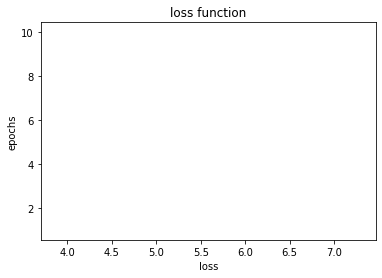

In [ ]:

# -*- coding: utf-8 -*-

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

cuda0 = torch.device('cuda:0')
########################################################################
#
transform1 = transforms.Compose([transforms.ToTensor(),transforms.Resize((227,227))])

batch_size = 20

dataset = torchvision.datasets.ImageFolder(root='/content/datasets/Mushrooms_3dataset(9528)/train', transform=transform1)
#trainset,testset = torch.utils.data.random_split(dataset, [8583, 950])
trainloader1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)

classes = ('Agaricus', 'Amanita', 'Boletus', 'Cortinarius','Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus')


########################################################################
# 2. Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes=12):
        super(AlexNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers
        self.conv1 = nn.Conv2d(self.in_channels, out_channels=96, kernel_size= 11, stride=4, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features=4096)
        self.fc2  = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=self.num_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = AlexNet(in_channels=3, num_classes=12)
net2 = AlexNet(in_channels=1, num_classes=12)

if torch.cuda.is_available():
    net.cuda()
    net2.cuda()

class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes=12):
        super(LeNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.in_channels, 6, 5)     #input channel: 1, output channel: 6, filter: 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_features=self.num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)     # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net3 = LeNet(in_channels=3, num_classes=12)
if torch.cuda.is_available():
    net3.cuda()
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
from itertools import chain

ce = nn.CrossEntropyLoss()

o3 = optim.Adam(net3.parameters(), lr=0.0001)
o2 = optim.Adam(chain(net2.parameters(), net3.parameters()), lr=0.0001)
o1 = optim.Adam(chain(net.parameters(), net2.parameters(),net3.parameters()), lr=0.0001)


########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

# loop over the dataset multiple times
for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(trainloader1, 0):

    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    if torch.cuda.is_available():
      inputs, labels = inputs.cuda(), labels.cuda()

    # zero the parameter gradients
    o3.zero_grad()
    o2.zero_grad()
    o1.zero_grad()

    # get a gray image of the original
    grey_inputs = transforms.Grayscale()(inputs)

    # get a 32x32 image of the gray image
    #small_grey_inputs = transforms.Resize((32,32))(grey_inputs)

    # get a 32x32 image of the color image
    small_inputs = transforms.Resize((32,32))(inputs)

    # forward
    outputs = net(inputs)
    outputs2 = net2(grey_inputs)
    outputs3 = net3(small_inputs)

    # loss function for all images
    lossNet = ce(outputs, labels)
    lossNet2 = ce(outputs2, labels)
    lossNet3 = ce(outputs3, labels)
    loss = lossNet + lossNet2 + lossNet3
    loss.backward()
    #torch.autograd.backward([lossNet, lossNet2, lossNet3])

    # optimize all models
    o3.step()
    o2.step()
    o1.step()

    # print loss statistics
    running_loss += loss.item()

  # print loss stats for each epoch
  print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / i))

  ### define plot
  plt.xlabel('loss')
  plt.ylabel('epochs')
  plt.title('loss function')
  plt.plot(running_loss/i, epoch+1)
  running_loss = 0.0



print('Finished Training')
plt.show()

########################################################################
# Let's quickly save our trained model:

PATH = '/content/drive/MyDrive/ColabProjects/final_project.pth'
torch.save(net.state_dict(), PATH)



In [ ]:
########################################################################
# 5. Test the trained network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

batch_size = 20
PATH = '/content/drive/MyDrive/ColabProjects/final_project-3branch-80E-20B.pth'
net.load_state_dict(torch.load(PATH))

dataset = torchvision.datasets.ImageFolder(root='/content/datasets/Mushrooms_3dataset(9528)/test', transform=transform1)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)

from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline

myf1 = 0
myprecision = 0
myrecall = 0
myfbeta = 0
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    if torch.cuda.is_available():
      inputs, labels = inputs.cuda(), labels.cuda()

    outputs1 = net(inputs)
    outputs = outputs1
    _, predictions = torch.max(outputs, 1)

    # calculate f1 score
    myf1 += f1_score(labels.cpu(), predictions.cpu(), average="macro")
    mystuff = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='macro', zero_division=0)
    myprecision += mystuff[0]
    myrecall += mystuff[1]
    myfbeta += mystuff[2]


    # collect the correct predictions for all classes
    total += labels.size(0)
    correct += (predictions == labels).sum().item()

    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
          correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

# print accuracy for all classes
print('Accuracy of the network on the',len(dataset), 'test images: %d %%' % (
        100 * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print("Accuracy for class {:5s} is: {:.1f}%".format(classname,accuracy))

# print accuracy
divider = len(dataset)/batch_size
print('F1',myf1/divider, '\nPrecision', myprecision/divider, '\nRecall',myrecall/divider, '\nF1 Beta', myfbeta/divider)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 1911 test images: 43 %
Accuracy for class Agaricus is: 58.5%
Accuracy for class Amanita is: 37.3%
Accuracy for class Boletus is: 70.7%
Accuracy for class Cortinarius is: 32.7%
Accuracy for class Entoloma is: 30.4%
Accuracy for class Exidia is: 66.7%
Accuracy for class Hygrocybe is: 68.5%
Accuracy for class Inocybe is: 24.2%
Accuracy for class Lactarius is: 27.5%
Accuracy for class Pluteus is: 12.4%
Accuracy for class Russula is: 51.6%
Accuracy for class Suillus is: 18.0%
F1 0.33335320168962707 
Precision 0.35703530533462496 
Recall 0.36302797731369174 
F1 Beta 0.33335320168962707
